In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('final_model_data.csv')
df.describe()

,Year,Effective Federal Funds Rate,Synthetic_Target_Rate,Deviation,Real GDP (Percent Change),Unemployment Rate,Inflation Rate,Deviation_abs,is_post_2008,is_crisis
count,35.000000,35.000000,35.000000,35.000000,34.000000,35.000000,35.000000,35.00000,35.000000,35.000000
mean,2000.000000,4.013714,3.992286,0.009143,2.868529,6.179429,2.820000,0.05600,0.285714,0.171429
std,10.246951,3.109405,3.076363,0.081615,1.903674,1.543897,1.124264,0.05932,0.458349,0.382385
min,1983.000000,0.090000,0.120000,-0.240000,-2.700000,3.970000,0.960000,0.00000,0.000000,0.000000
25%,1991.500000,0.895000,0.905000,-0.020000,1.885000,5.010000,2.100000,0.02000,0.000000,0.000000
50%,2000.000000,4.200000,4.110000,0.020000,2.750000,5.780000,2.390000,0.03000,0.000000,0.000000
75%,2008.500000,6.040000,5.995000,0.050000,4.310000,7.095000,3.790000,0.06000,1.000000,0.000000
max,2017.000000,10.220000,10.150000,0.180000,7.820000,9.610000,5.020000,0.24000,1.000000,1.000000


Text(0, 0.5, 'Rate')

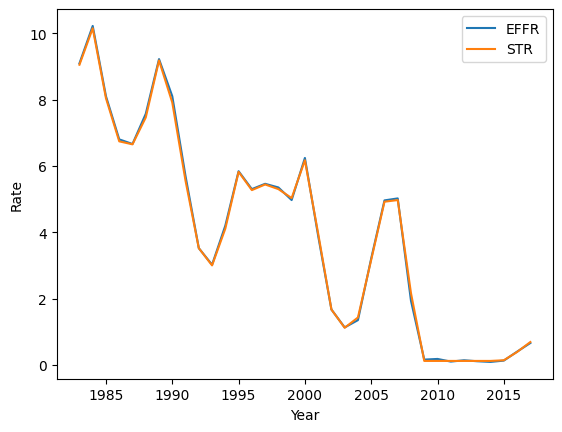

In [4]:
plt.plot(df['Year'], df['Effective Federal Funds Rate'], label='EFFR')
plt.plot(df['Year'], df['Synthetic_Target_Rate'], label = 'STR')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Rate')

Text(0.5, 0, 'Year')

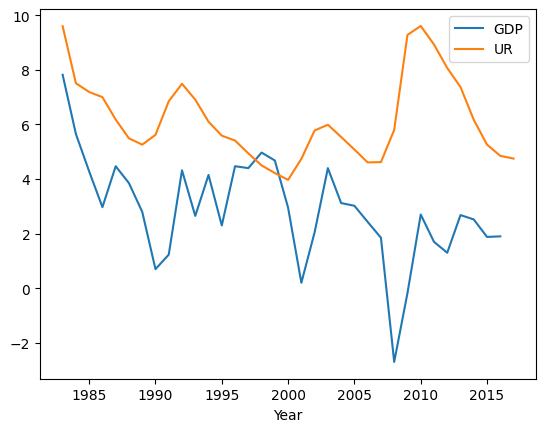

In [8]:
plt.plot(df['Year'], df['Real GDP (Percent Change)'], label='GDP')
plt.plot(df['Year'], df['Unemployment Rate'], label='UR')
plt.legend()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

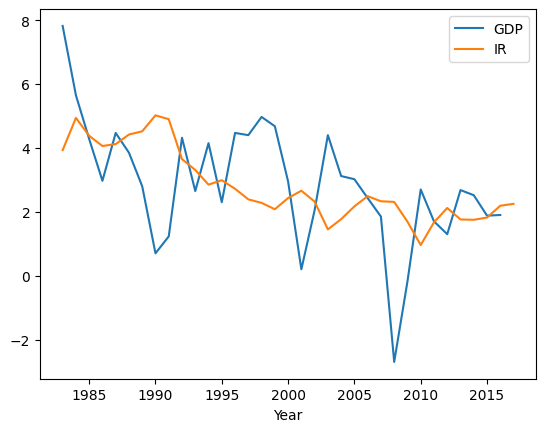

In [9]:
plt.plot(df['Year'], df['Real GDP (Percent Change)'], label='GDP')
plt.plot(df['Year'], df['Inflation Rate'], label='IR')
plt.legend()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

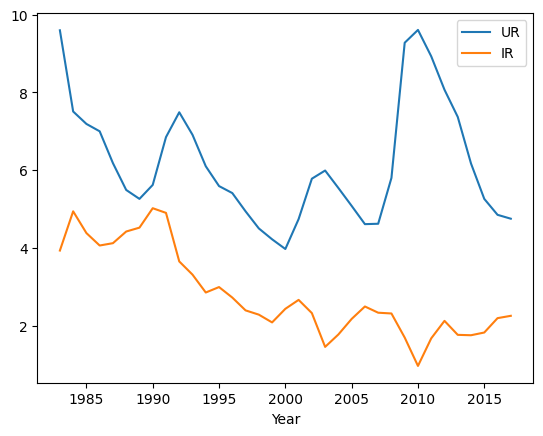

In [12]:
plt.plot(df['Year'], df['Unemployment Rate'], label='UR')
plt.plot(df['Year'], df['Inflation Rate'], label='IR')
plt.legend()
plt.xlabel('Year')

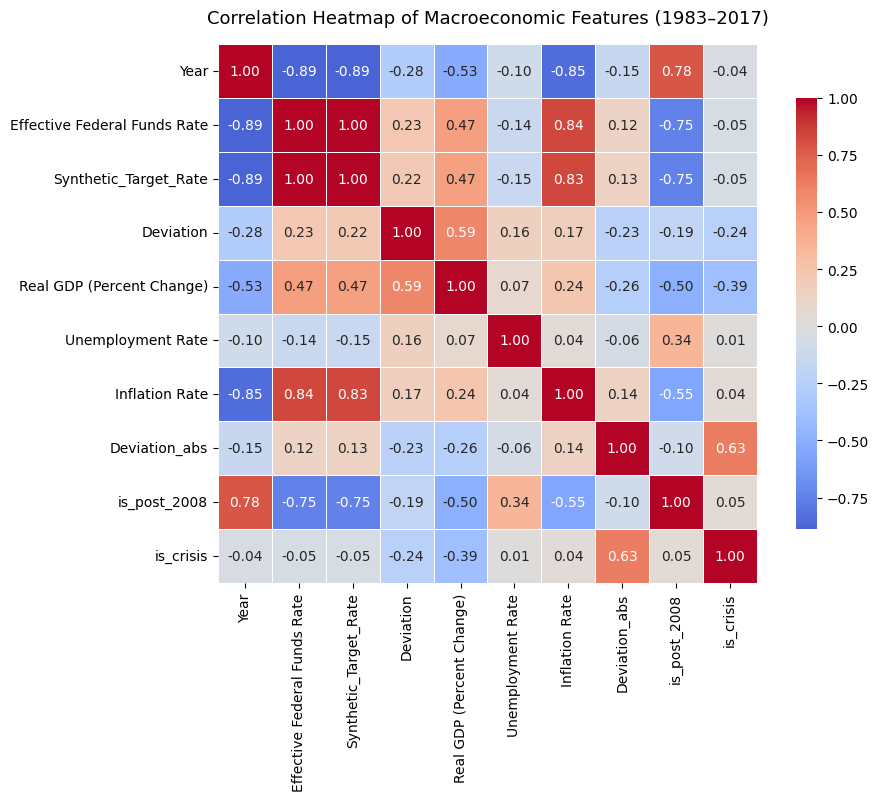

In [11]:
# Compute correlation matrix (numeric columns only)
corr = df.corr(numeric_only=True)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr,
    annot=True,               # show correlation values
    fmt=".2f",                # 2 decimal precision
    cmap="coolwarm",          # diverging color scheme
    center=0,                 # center at zero
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Macroeconomic Features (1983–2017)", fontsize=13, pad=15)
plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneOut

In [14]:
df = pd.read_csv("final_model_data.csv")

# Feature sets
pos_feats = ["Synthetic_Target_Rate", "Real GDP (Percent Change)", "Deviation_abs", "is_post_2008", "is_crisis"]
neg_feats = ["Unemployment Rate", "Deviation", "is_post_2008", "is_crisis"]
y = df["Inflation Rate"].values

loo = LeaveOneOut()
pred_pos, pred_neg, true_y = [], [], []

for train_idx, test_idx in loo.split(df):
    X_train_pos, X_test_pos = df[pos_feats].iloc[train_idx], df[pos_feats].iloc[test_idx]
    X_train_neg, X_test_neg = df[neg_feats].iloc[train_idx], df[neg_feats].iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Two forests per fold
    rf_pos = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
    rf_neg = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
    rf_pos.fit(X_train_pos, y_train)
    rf_neg.fit(X_train_neg, y_train)

    pred_pos.append(rf_pos.predict(X_test_pos)[0])
    pred_neg.append(rf_neg.predict(X_test_neg)[0])
    true_y.append(y_test[0])

# Evaluate each sub-model
r2_pos, mse_pos = r2_score(true_y, pred_pos), mean_squared_error(true_y, pred_pos)
r2_neg, mse_neg = r2_score(true_y, pred_neg), mean_squared_error(true_y, pred_neg)

# Compute weights using R² and inverse MSE
w_pos = (r2_pos / mse_pos) / ((r2_pos / mse_pos) + (r2_neg / mse_neg))
w_neg = 1 - w_pos

# Weighted ensemble
pred_final = w_pos * np.array(pred_pos) + w_neg * np.array(pred_neg)
r2_final, mse_final = r2_score(true_y, pred_final), mean_squared_error(true_y, pred_final)

print(f"R² (pos): {r2_pos:.3f}, R² (neg): {r2_neg:.3f}, R² (ensemble): {r2_final:.3f}")
print(f"MSE (ensemble): {mse_final:.4f}, weights → pos: {w_pos:.2f}, neg: {w_neg:.2f}")

R² (pos): 0.628, R² (neg): 0.109, R² (ensemble): 0.642
MSE (ensemble): 0.4393, weights → pos: 0.93, neg: 0.07


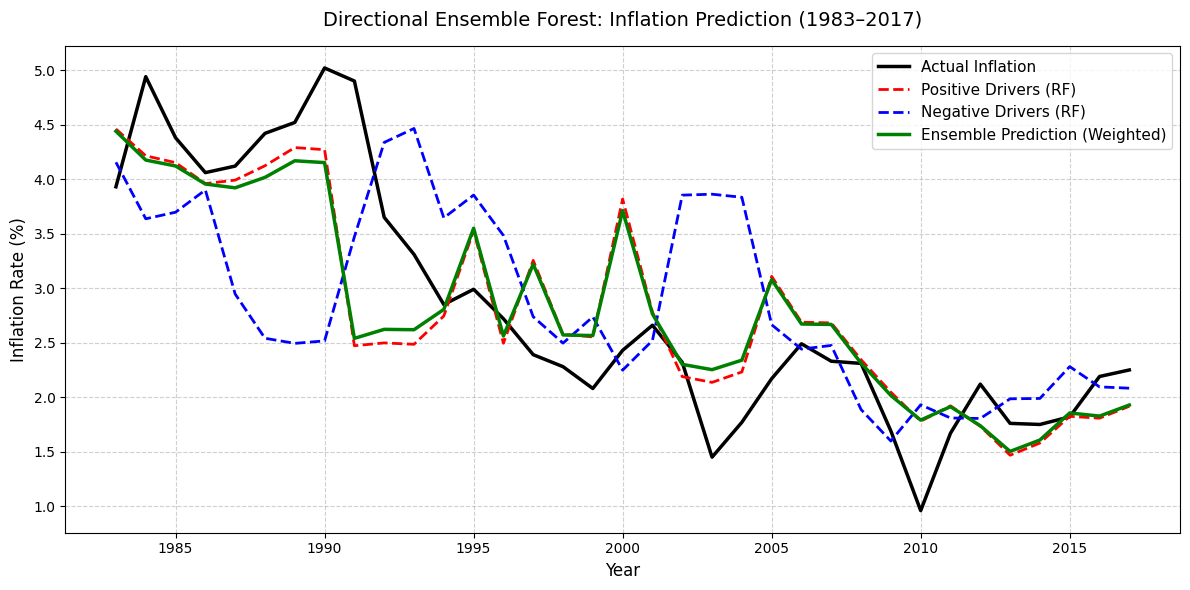

In [15]:
# Convert everything to numpy arrays
true_y = np.array(true_y)
pred_pos = np.array(pred_pos)
pred_neg = np.array(pred_neg)
pred_final = np.array(pred_final)
years = df["Year"].values  # assuming your dataframe has a Year column

# Plot
plt.figure(figsize=(12,6))
plt.plot(years, true_y, label="Actual Inflation", color="black", linewidth=2.5)
plt.plot(years, pred_pos, label="Positive Drivers (RF)", color="red", linestyle="--", linewidth=2)
plt.plot(years, pred_neg, label="Negative Drivers (RF)", color="blue", linestyle="--", linewidth=2)
plt.plot(years, pred_final, label="Ensemble Prediction (Weighted)", color="green", linewidth=2.5)

plt.title("Directional Ensemble Forest: Inflation Prediction (1983–2017)", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

<BarContainer object of 34 artists>

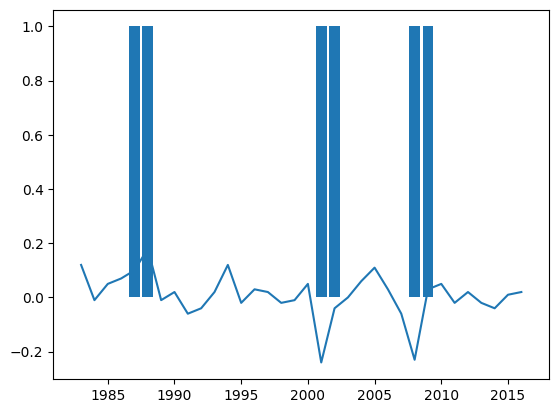

In [27]:
plt.plot(df['Year'], df['Deviation'])
plt.bar(df['Year'], df['is_crisis'])

In [35]:
# --- 1) Build ternary regime label from your crisis flag + deviation direction ---
# Set a small threshold so micro-noise doesn't trigger easing. Tune if needed.
NEG_DEV_EPS = -0.03

regime = np.zeros(len(df), dtype=int)
# Start from your crisis flag as +1 (tightening by default)
regime[df["is_crisis"] == 1] = +1
# Flip to -1 when it's a crisis year *and* deviation is clearly negative (easing/liquidity support)
regime[(df["is_crisis"] == 1) & (df["Deviation"] <= NEG_DEV_EPS)] = -1
df["regime3"] = regime

# --- 2) Feature sets (remove Deviation_abs; keep Deviation in both) ---
pos_feats = ["Synthetic_Target_Rate", "Real GDP (Percent Change)", "Deviation", "is_post_2008", "regime3"]
neg_feats = ["Unemployment Rate", "Deviation", "is_post_2008", "regime3"]
y = df["Inflation Rate"].values

# --- 3) LOOCV training for the two forests ---
loo = LeaveOneOut()
pred_pos, pred_neg, true_y = [], [], []

for train_idx, test_idx in loo.split(df):
    X_train_pos, X_test_pos = df[pos_feats].iloc[train_idx], df[pos_feats].iloc[test_idx]
    X_train_neg, X_test_neg = df[neg_feats].iloc[train_idx], df[neg_feats].iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_pos = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
    rf_neg = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)

    rf_pos.fit(X_train_pos, y_train)
    rf_neg.fit(X_train_neg, y_train)

    pred_pos.append(rf_pos.predict(X_test_pos)[0])
    pred_neg.append(rf_neg.predict(X_test_neg)[0])
    true_y.append(y_test[0])

# --- 4) Performance-weighted ensemble (R² and inverse MSE) ---
r2_pos, mse_pos = r2_score(true_y, pred_pos), mean_squared_error(true_y, pred_pos)
r2_neg, mse_neg = r2_score(true_y, pred_neg), mean_squared_error(true_y, pred_neg)

# Safe-guard: if any R² <= 0, clamp at a tiny positive so weights don't go negative or blow up
r2_pos_safe = max(r2_pos, 1e-6)
r2_neg_safe = max(r2_neg, 1e-6)

score_pos = r2_pos_safe / max(mse_pos, 1e-9)
score_neg = r2_neg_safe / max(mse_neg, 1e-9)

w_pos = score_pos / (score_pos + score_neg)
w_neg = 1.0 - w_pos

pred_final = w_pos * np.array(pred_pos) + w_neg * np.array(pred_neg)
r2_final, mse_final = r2_score(true_y, pred_final), mean_squared_error(true_y, pred_final)

print(f"R² (pos): {r2_pos:.3f}, R² (neg): {r2_neg:.3f}, R² (ensemble): {r2_final:.3f}")
print(f"MSE (ensemble): {mse_final:.4f}, weights → pos: {w_pos:.2f}, neg: {w_neg:.2f}")

R² (pos): 0.618, R² (neg): 0.119, R² (ensemble): 0.636
MSE (ensemble): 0.4464, weights → pos: 0.92, neg: 0.08


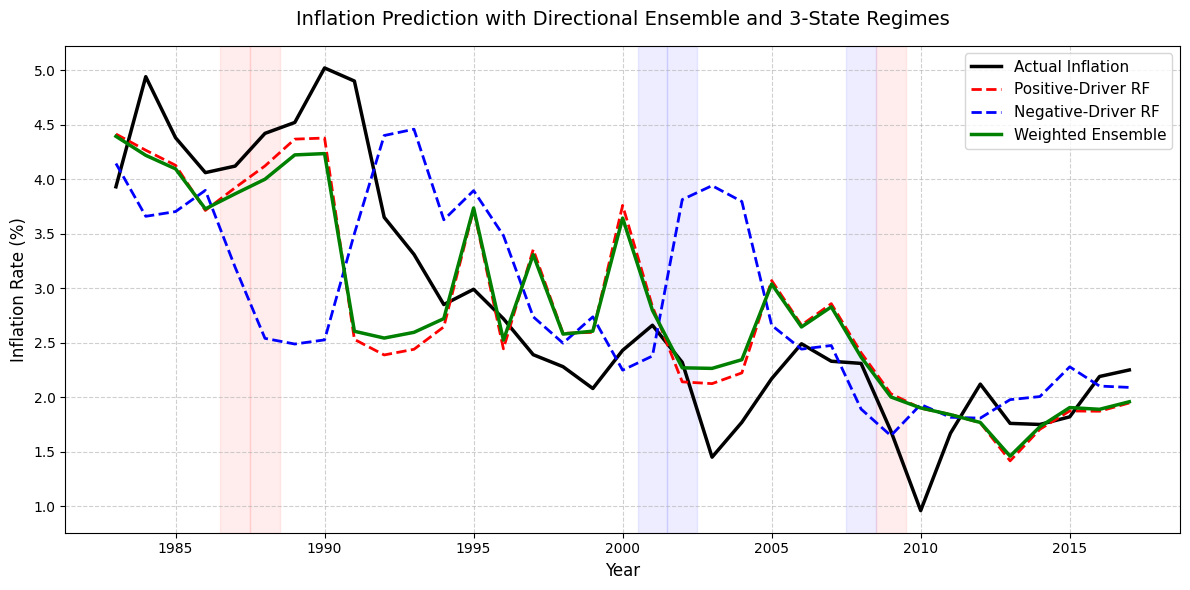

In [36]:
import matplotlib.pyplot as plt
import numpy as np

years = df["Year"].values
true_y = np.array(true_y)
pred_pos = np.array(pred_pos)
pred_neg = np.array(pred_neg)
pred_final = np.array(pred_final)

plt.figure(figsize=(12,6))
plt.plot(years, true_y, color="black", linewidth=2.5, label="Actual Inflation")
plt.plot(years, pred_pos, "--", color="red", linewidth=2, label="Positive-Driver RF")
plt.plot(years, pred_neg, "--", color="blue", linewidth=2, label="Negative-Driver RF")
plt.plot(years, pred_final, color="green", linewidth=2.5, label="Weighted Ensemble")

# Shade regimes: -1 (easing) blue, +1 (tightening) red
for yr, reg in zip(years, df["regime3"]):
    if reg == -1:
        plt.axvspan(yr-0.5, yr+0.5, color="blue", alpha=0.07)
    elif reg == +1:
        plt.axvspan(yr-0.5, yr+0.5, color="red", alpha=0.07)

plt.title("Inflation Prediction with Directional Ensemble and 3-State Regimes", fontsize=14, pad=15)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Inflation Rate (%)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

<BarContainer object of 5 artists>

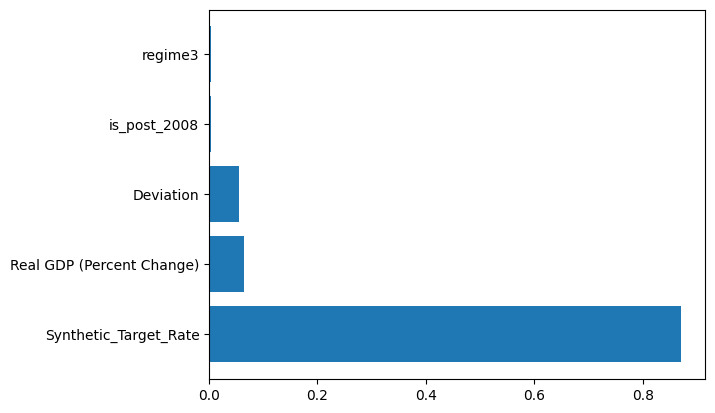

In [37]:
importances_pos = rf_pos.feature_importances_
plt.barh(pos_feats, importances_pos)

In [38]:
!pip freeze > requirements.txt